In [110]:
import numpy as np
import matplotlib.pyplot as plt

In [111]:
class GridworldEnv:
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

    def __init__(self, shape=(4, 4)):
        self.shape = shape
        self.num_states = np.prod(shape)
        self.num_actions = 4  # up, down, left, right
        self.terminal_states = [0, self.num_states - 1]
        self.actions = [self.UP, self.DOWN, self.LEFT, self.RIGHT]
        self.P = self._build_transition_probabilities()

    def _get_next_state(self, s, a):
        row, col = divmod(s, self.shape[1])
        if a == self.UP:
            next_row, next_col = max(row - 1, 0), col
        elif a == self.DOWN:
            next_row, next_col = min(row + 1, self.shape[0] - 1), col
        elif a == self.LEFT:
            next_row, next_col = row, max(col - 1, 0)
        elif a == self.RIGHT:
            next_row, next_col = row, min(col + 1, self.shape[1] - 1)
        else:
            next_row, next_col = row, col  # stay in place if invalid action
        return next_row * self.shape[1] + next_col

    def _build_transition_probabilities(self):
        P = {}
        for s in range(self.num_states):
            P[s] = {}
            for a in self.actions:
                if s in self.terminal_states:
                    P[s][a] = [(1.0, s, 0, True)]  # (prob, next_state, reward, terminal)
                else:
                    next_state = self._get_next_state(s, a)
                    done = next_state in self.terminal_states
                    P[s][a] = [(1.0, next_state, -1, done)]
        return P

In [112]:
def policy_evaluation(env, policy, gamma=1.0, theta=1e-4, track_iters=None, in_place=True):
    """
    Evaluate a given policy for the provided Gridworld environment using iterative policy evaluation.

    Args:
        env: An instance of GridworldEnv.
        policy: A 2D numpy array of shape (num_states, num_actions), where 
                policy[s, a] is the probability of taking action a in state s.
        gamma: Discount factor for future rewards (default: 1.0).
        theta: Convergence threshold - algorithm stops when the maximum change in value 
               function between iterations is less than this value (default: 1e-4).
        track_iters: Optional list of iteration indices at which to store a copy of the 
                     value function V for later inspection (e.g., [0, 1, 2, 3, 10]).
        in_place: Update strategy for value function:
                 • True: Updates V in-place (asynchronous) - faster convergence but 
                   uses latest updated values within the same iteration
                 • False: Uses separate arrays (synchronous) - more stable but slower,
                   all states updated using values from previous iteration only

    Returns:
        tracked_values: A dictionary mapping iteration indices (from track_iters) and 
                       'final' to the corresponding value function snapshots.
    """

    if track_iters is None:
        track_iters = []
    
    V = np.zeros(env.num_states)
    tracked_values = {}
    iteration = 0
    
    # Track initial value function if requested
    if iteration in track_iters:
        tracked_values[iteration] = V.copy()

    while True:
        delta = 0
        
        # Create new array for synchronous update, or use existing V for in-place
        new_V = V if in_place else np.zeros_like(V)
        
        for state in range(env.num_states):
            old_value = V[state]
            new_value = _calculate_state_value(env, policy, V, state, gamma)
            new_V[state] = new_value
            delta = max(delta, abs(old_value - new_value))
        
        # Update V reference for synchronous case
        if not in_place:
            V = new_V
        
        iteration += 1
        
        # Track value function at specified iterations
        if iteration in track_iters:
            tracked_values[iteration] = V.copy()
        
        # Check convergence
        if delta < theta:
            break

    tracked_values['final'] = V.copy()
    return tracked_values


def _calculate_state_value(env, policy, V, state, gamma):
    """
    Calculate the value of a specific state under the given policy.
    
    Args:
        env: Environment instance
        policy: Policy array
        V: Value function array
        state: State index
        gamma: Discount factor
    
    Returns:
        state_value: Calculated value for the state
    """
    state_value = 0
    
    for action, action_prob in enumerate(policy[state]):
        for prob, next_state, reward, done in env.P[state][action]:
            state_value += action_prob * prob * (reward + gamma * V[next_state])
    
    return state_value

In [113]:
def plot_values(ax, values, env, title=""):
    """
    Visualize state values on a grid layout.
    
    Creates a grid visualization where each cell displays the value of the corresponding state.

    Args:
        ax: Matplotlib axis object for plotting.
        values: 1D numpy array of length env.num_states containing the value for each state.
                State index i corresponds to values[i].
        env: GridworldEnv instance providing shape information and state count.
        title: Title displayed above the grid (default: "Values").
    
    Note:
        - States are mapped to grid positions using row-major order (left-to-right, top-to-bottom)
        - Y-axis is inverted so that state 0 appears at top-left corner
        - Values are displayed with 1 decimal place precision
    """

    nrow, ncol = env.shape
    # Draw grid lines
    for i in range(nrow + 1):
        ax.axhline(i, color='black', linewidth=1)
    for j in range(ncol + 1):
        ax.axvline(j, color='black', linewidth=1)
    
    # Fill in values for each cell
    for state in range(env.num_states):
        row, col = divmod(state, ncol)

        center_x = col + 0.5
        center_y = nrow - 0.5 - row  # y axis: top to bottom
        value_text = f"{values[state]:.1f}"
        ax.text(center_x, center_y, value_text,
                ha='center', va='center', fontsize=12, fontweight='bold')
        
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])


def plot_policy(ax, policy, env, title=""):
    """
    Visualize a stochastic policy using arrows on a grid layout.
    
    Creates a grid visualization where arrows represent actions and their transparency
    indicates the probability of taking that action. Multiple arrows per cell show
    stochastic policies, while single arrows indicate deterministic actions.

    Args:
        ax: Matplotlib axis object for plotting.
        policy: 2D numpy array of shape (num_states, num_actions) where policy[s, a]
                represents the probability of taking action a in state s.
        env: GridworldEnv instance providing shape and action space information.
        title: Title displayed above the grid (default: "Policy").
    
    Note:
        - Arrow directions: UP (↑), DOWN (↓), LEFT (←), RIGHT (→)
        - Arrow transparency (alpha) scales with probability: higher prob = more opaque
        - Only actions with probability > 0 are displayed
    """
    
    nrow, ncol = env.shape
    num_states = env.num_states
    num_actions = env.num_actions

    # Fill terminal states with gray background
    for state in range(num_states):
        if state in env.terminal_states:
            row, col = divmod(state, env.shape[1])
            ax.add_patch(plt.Rectangle((col, nrow - 1 - row), 1, 1, 
                                     facecolor='lightgray', alpha=1))

    # Draw grid lines
    for i in range(nrow + 1):
        ax.axhline(i, color='black', linewidth=1)
    for j in range(ncol + 1):
        ax.axvline(j, color='black', linewidth=1)

    # Define arrow directions for each action
    arrow_directions = {
        0: (0, 0.25),    # UP
        1: (0, -0.25),   # DOWN
        2: (-0.25, 0),   # LEFT
        3: (0.25, 0)     # RIGHT
    }

    # Draw arrows for each state and action with probability > 0
    for state in range(num_states):
        row = state // ncol
        col = state % ncol
        center_x = col + 0.5
        center_y = nrow - 0.5 - row  # y axis: top to bottom

        for action in range(num_actions):
            prob = policy[state][action]
            if prob > 0:
                dx, dy = arrow_directions[action]
                ax.arrow(center_x, center_y, dx, dy,
                         head_width=0.08, head_length=0.08,
                         fc='black', ec='black', linewidth=2, alpha=1)

    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

In [114]:
def compute_greedy_policy(env, V, gamma=1.0):
    """
    Compute the greedy policy from a value function using action-value calculations.
    
    For each state, computes Q-values for all actions and creates a policy that selects
    the action(s) with maximum expected return. When multiple actions have the same
    maximum Q-value, probability is distributed equally among them.

    Args:
        env: Instance of GridworldEnv providing environment dynamics and terminal states.
        V: 1D numpy array of state values, shape (env.num_states,).
        gamma: Discount factor applied to future rewards when computing Q-values (default: 1.0).

    Returns:
        policy: Greedy policy as a numpy array of shape (env.num_states, env.num_actions).
                Each policy[s, a] represents the probability of taking action a in state s.
    
    Note:
        - Terminal states have zero probability for all actions
        - Ties between actions are broken by uniform distribution
        - Q-values computed as: Q(s,a) = Σ P(s'|s,a) * [R(s,a,s') + γ * V(s')]
        - Q-values are rounded to 2 decimal places before comparison to handle numerical precision
    """
    policy = np.zeros((env.num_states, env.num_actions))
    
    for state in range(env.num_states):
        if state in env.terminal_states:
            continue
        
        # Compute Q-values for each action
        action_values = np.zeros(env.num_actions)
        for action in range(env.num_actions):
            for prob, next_state, reward, done in env.P[state][action]:
                action_values[action] += prob * (reward + gamma * V[next_state])
        action_values = np.round(action_values, 2)

        # Set greedy policy (handle ties)
        best_actions = np.where(action_values == np.max(action_values))[0]
        policy[state, best_actions] = 1.0 / len(best_actions)
    
    return policy

In [119]:
def plot_policy_evaluation_results(tracked_values, env, title="", figsize=None):
    """
    Visualize policy evaluation results showing value functions and corresponding greedy policies.
    
    Creates a grid of subplots where each row shows the value function and greedy policy
    for a specific iteration. Iterations are displayed in the order they appear in the
    tracked_values dictionary.

    Args:
        tracked_values: Dictionary from policy_evaluation, mapping iteration indices and 'final' 
                       to value function arrays.
        env: Instance of GridworldEnv providing environment structure.
        title: Title displayed at the top of the entire figure (default: "Policy Evaluation Results").
        figsize: Figure size as (width, height). If None, auto-calculated based on number of iterations.
    
    Note:
        - Each row displays one iteration with value function (left) and greedy policy (right)
        - 'final' iteration is displayed as 'k = ∞'
        - Greedy policies are computed on-the-fly from the value functions
    """
    if not tracked_values:
        raise ValueError("tracked_values dictionary is empty")
    
    iterations = list(tracked_values.keys())
    n_rows = len(iterations)
    
    figsize = figsize or (10, 3.2 * n_rows)
    fig, axes = plt.subplots(n_rows, 2, figsize=figsize)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(title, fontsize=16, fontweight='bold')

    for i, iteration in enumerate(iterations):
        V = tracked_values[iteration]
        iter_label = 'k = ∞' if iteration == 'final' else f'k = {iteration}'
        
        # Plot value function
        if i == 0:
            values_title = f'$\\tilde{{v}}_k$ for Random Policy'
            plot_values(axes[i, 0], V, env, values_title)
        else:
            plot_values(axes[i, 0], V, env, None)
        axes[i, 0].set_ylabel(iter_label, rotation=0, ha='right', va='center', fontsize=12, fontweight='bold')
        
        # Plot greedy policy
        policy_title = 'Greedy Policy w.r.t $\\tilde{{v}}_k$' if i == 0 else None
        greedy_policy = compute_greedy_policy(env, V)
        plot_policy(axes[i, 1], greedy_policy, env, policy_title)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [120]:
env = GridworldEnv()
policy = np.ones((env.num_states, env.num_actions)) / env.num_actions

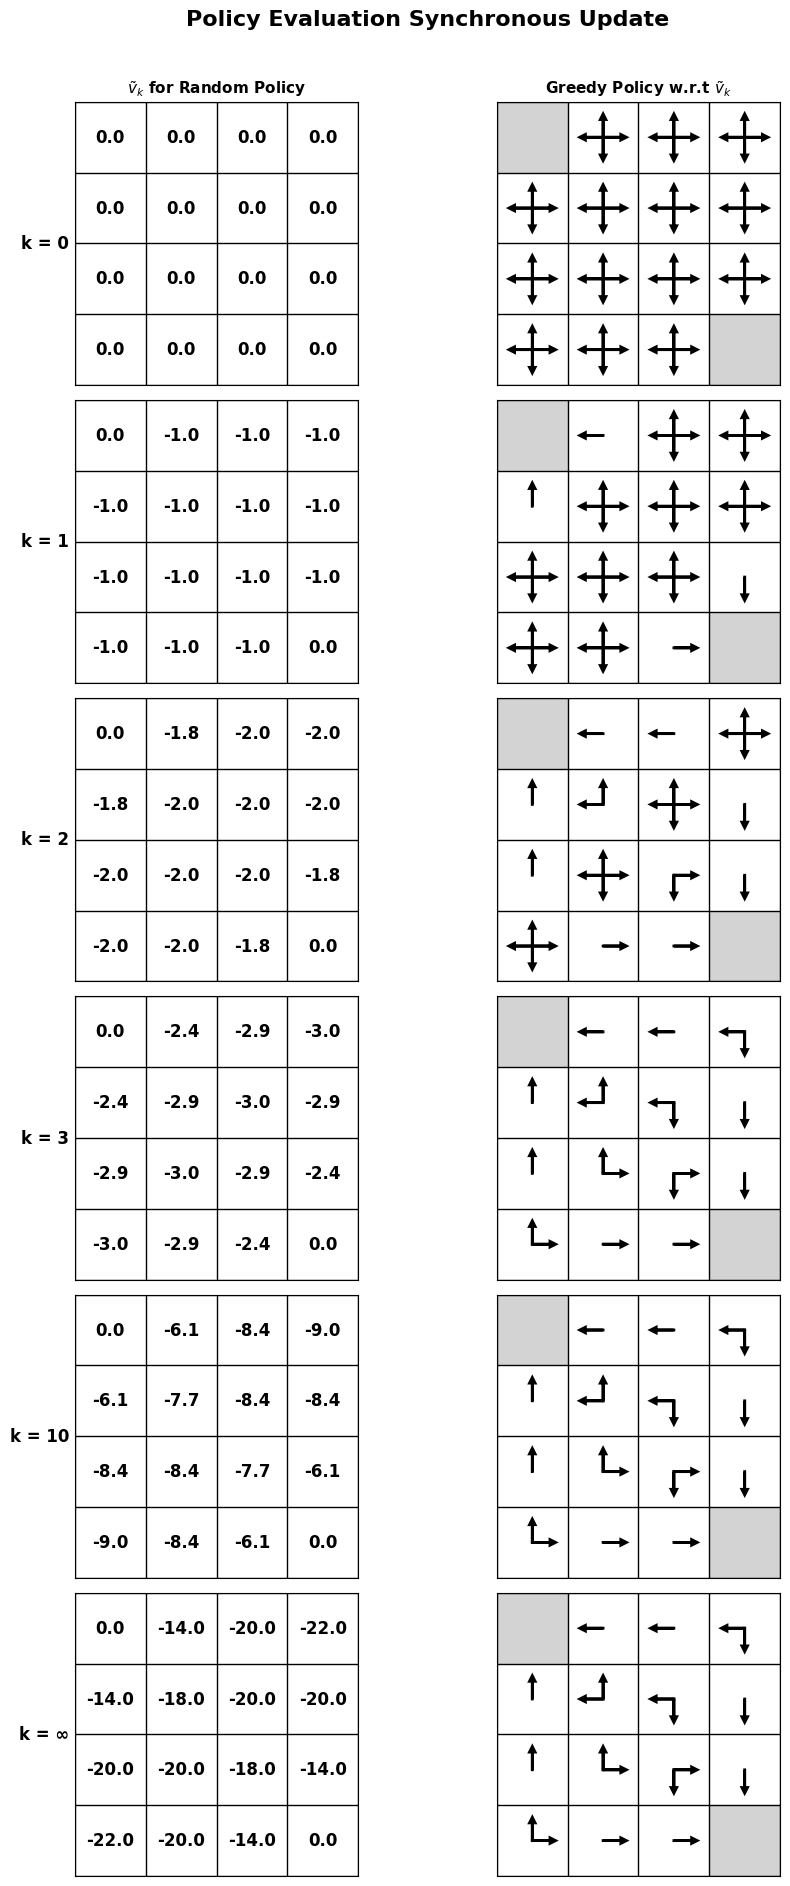

In [122]:
tracked_values = policy_evaluation(env, policy, track_iters=[0, 1, 2, 3, 10], in_place=False)
plot_policy_evaluation_results(tracked_values, env, title="Policy Evaluation Synchronous Update")

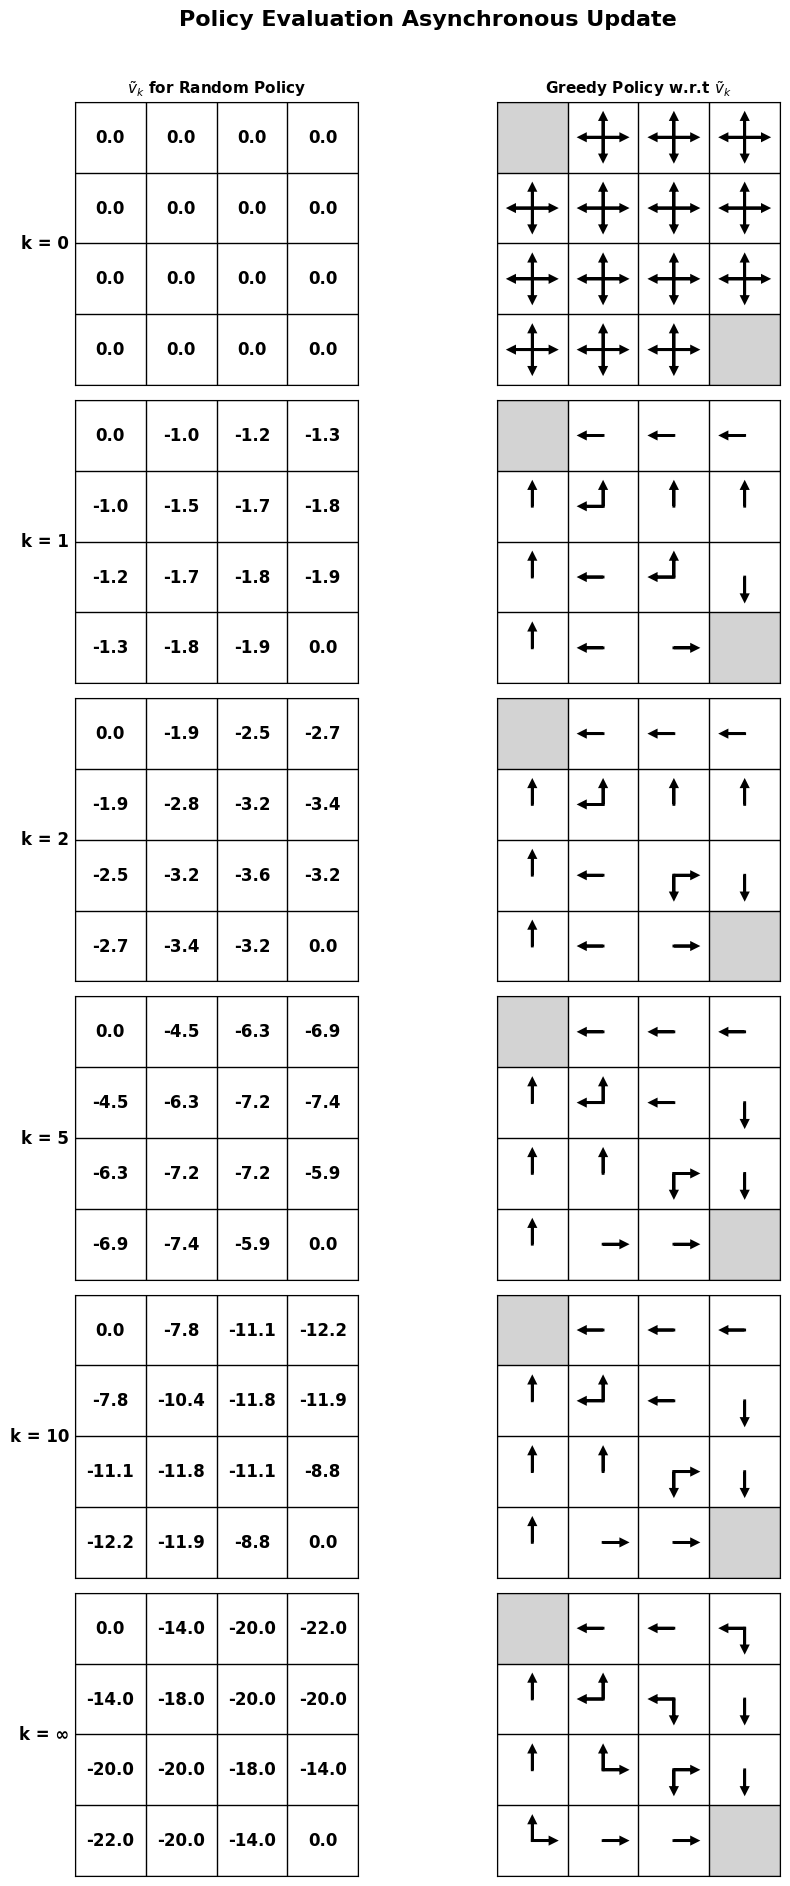

In [123]:
tracked_values = policy_evaluation(env, policy, track_iters=[0, 1, 2, 5, 10], in_place=True)
plot_policy_evaluation_results(tracked_values, env, title="Policy Evaluation Asynchronous Update")

- Change round in compute greedy policy to see =))